# Creation of a test dataset for the image recognition task

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.ndimage.interpolation import rotate
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models, Sequential, Input, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import load_model
import joblib

In [5]:
path_test_ds = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset'
im_test = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\971.jpg'

(1284, 960, 3)

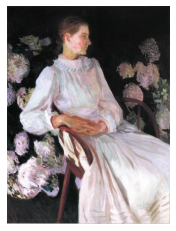

In [8]:
img_raw = plt.imread(im_test)
plt.imshow(img_raw)
plt.axis('off')
img_raw.shape

## Check embedding equality after image save

In [9]:
im_original = load_img(im_test, grayscale=False, color_mode='rgb', target_size=(224, 224), interpolation='bilinear')
im_original = np.array(im_original.getdata()).reshape(im_original.size[0], im_original.size[1], 3)
im_original = np.expand_dims(im_original,axis =0)

plt.imsave(r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\971_copy.jpg', img_raw)

im_copy = load_img(r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\971_copy.jpg', grayscale=False, color_mode='rgb', target_size=(224, 224), interpolation='bilinear')
im_copy = np.array(im_copy.getdata()).reshape(im_copy.size[0], im_copy.size[1], 3)
im_copy = np.expand_dims(im_copy,axis =0)


In [11]:
model = load_model('../models/Full_training/20201212_205911_VGG16_v3_27/')

layer_outputs = [model.layers[-1].input]
embedding_model = models.Model(inputs=model.input, outputs=layer_outputs)

image_embeddings_im_original = embedding_model.predict(im_original)
image_embeddings_im_copy = embedding_model.predict(im_copy)


In [33]:
im_diff_df = pd.DataFrame(np.hstack((image_embeddings_im_original.T, image_embeddings_im_copy.T)))
im_diff_df['diff'] = im_diff_df[1] - im_diff_df[0]
im_diff_df[['diff']].head()

,diff
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


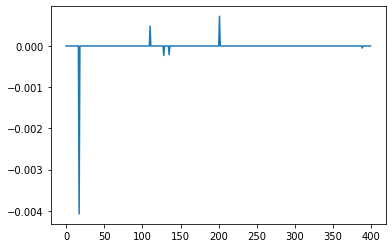

In [34]:
plt.plot(im_diff_df['diff'])

##  Image transformations

In [352]:
max_crop_ratio = 0.2
max_extend_ratio = 0.1
max_rotation = 10
max_contrast_modif = 0.2
max_color_balance_modif = 0.2
max_noise = 0.1

In [353]:
def im_compare(im_orig, im_modif):
    fig, ax = plt.subplots(1, 2, figsize= (10, 4))
    ax[0].imshow(im_orig)
    ax[0].axis('off')
    ax[0].set_title('Original image')
    ax[1].imshow(im_modif)
    ax[1].axis('off')
    ax[1].set_title('Modified image')

In [354]:
def image_crop(image):
    
    if image.ndim == 3:
        x, y, z = image.shape
    else: 
        x, y = image.shape
        
    x1 = round(max_crop_ratio*random.randint(0, x))
    y1 = round(max_crop_ratio*random.randint(0, y))
    dx = x - x1 - round(max_crop_ratio*random.randint(0, x))
    dy = y - y1 - round(max_crop_ratio*random.randint(0, y))
    if image.ndim == 3:
        cropped_image = image[x1:x1 + dx, y1:y1 + dy,:]
    else: 
        cropped_image = image[x1:x1 + dx, y1:y1 + dy]

    return cropped_image

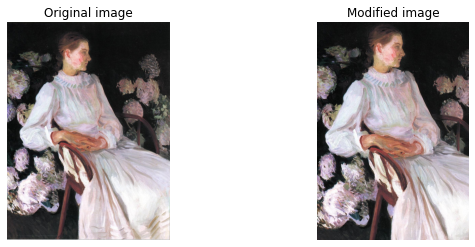

In [373]:
im_compare(img_raw, image_crop(img_raw))

In [356]:
def image_extend(image):
    if image.ndim == 3:
        x, y, z = image.shape
    else: 
        x, y = image.shape
        
    x1 = round(max_extend_ratio*random.randint(0, x))
    y1 = round(max_extend_ratio*random.randint(0, y))
    x2 = round(max_extend_ratio*random.randint(0, x))
    y2 = round(max_extend_ratio*random.randint(0, y))
    if image.ndim == 3:
        extended_image = np.random.randint(255, size = (x+x1+x2, y+y1+y2,z))
        extended_image[x1:x1+x, y1:y1+y,:] = image
    else:
        extended_image = np.random.randint(255, size = (x+x1+x2, y+y1+y2))
        extended_image[x1:x1+x, y1:y1+y] = image
        
    return np.uint8(extended_image)

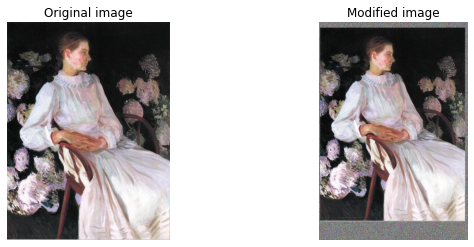

In [374]:
im_compare(img_raw, image_extend(img_raw))

In [358]:
def image_rotate(image):
    rotated = rotate(image, angle=max_rotation*random.random(), reshape = False)
    return np.uint8(rotated)

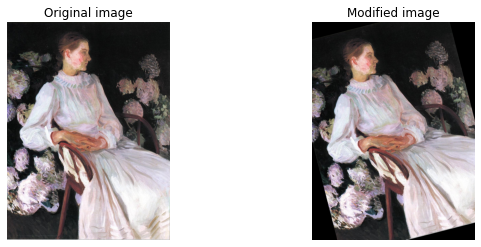

In [375]:
im_compare(img_raw, image_rotate(img_raw))

In [360]:
def image_contrast(image):
    image_c = image*random.uniform(1-3*max_contrast_modif, 1+max_contrast_modif)
    image_c = image_c - image_c.mean() + image.mean()
    image_c[image_c > 255] = 255
    image_c[image_c < 0] = 0
    return np.uint8(image_c)

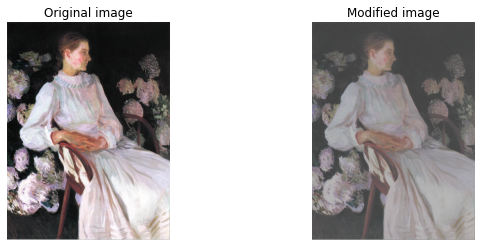

In [378]:
im_compare(img_raw, image_contrast(img_raw))

In [362]:
def image_color_balance(image):
    image_c = image.copy()
    for i in range(3):
        image_c[:,:,i] = image[:,:,i]*random.uniform(1-max_color_balance_modif, 1)
        image_c[:,:,i] = image_c[:,:,i] - image_c[:,:,i].mean() + image_c[:,:,i].mean()
    image_c[image_c > 255] = 255
    image_c[image_c < 0] = 0
    return np.uint8(image_c)

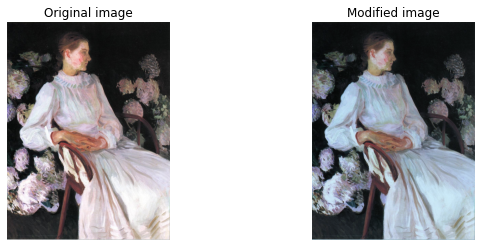

In [383]:
im_compare(img_raw, image_color_balance(img_raw))

In [364]:
def image_noise(image):
    image_c = image + max_noise*np.random.randint(-255, 255, size = image.shape)
    image_c[image_c > 255] = 255
    image_c[image_c < 0] = 0
    return np.uint8(image_c)

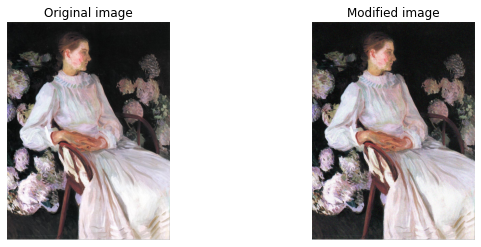

In [365]:
im_compare(img_raw, image_noise(img_raw))

## Dataset_generation
on test set !

In [366]:
path_im_orig = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Test'
img_list = []
for dir_path in os.listdir(path_im_orig):
    img_list += [os.path.join(dir_path, p) for p in os.listdir(os.path.join(path_im_orig, dir_path))]

In [367]:
n_im_test = 20
ind_list = np.random.randint(len(img_list), size = (1,n_im_test))
im_test_list = [img_list[i] for i in ind_list[0]]

In [384]:
for img in im_test_list:
    im_orig = plt.imread(os.path.join(path_im_orig, img))
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1]), im_orig)
    #im_modif = image_crop(im_orig)
    #im_compare(im_orig, im_modif)
    #plt.imsave(os.path.join(path_test_ds, os.path.split(img)[1].replace('.jpg', '_1.jpg')), im_modif)
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_1.jpg')), image_crop(im_orig))
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_2.jpg')), image_extend(im_orig))
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_3.jpg')), image_rotate(im_orig))
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_4.jpg')), image_contrast(im_orig))
    if im_orig.ndim == 3:
        plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_5.jpg')), image_color_balance(im_orig))
    plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_6.jpg')), image_noise(im_orig))
    if im_orig.ndim == 3:
        plt.imsave(os.path.join(path_test_ds, '_all', os.path.split(img)[1].replace('.jpg', '_7.jpg')), image_noise(image_color_balance(image_contrast(image_rotate(image_crop(im_orig))))))

2